In [1]:
!pip install openrouteservice
!pip install scikit-learn


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import joblib
import openrouteservice
from openrouteservice import convert
import time

In [62]:
import pandas as pd
import numpy as np
import random

# Number of records to generate
n = 1000

# Generate random traffic data
traffic_volume = np.random.randint(50, 500, size=n)  # Traffic volume between 50 and 500 vehicles
junctions = np.random.randint(1, 10, size=n)  # Random junction IDs (between 1 and 10)
incident_types = random.choices(['Accident', 'Roadwork', 'Congestion'], k=n)  # Random incident types

# Generate random weather data
temperature = np.random.uniform(-10, 40, size=n)  # Temperature between -10°C and 40°C
humidity = np.random.uniform(30, 100, size=n)  # Humidity between 30% and 100%
wind_speed = np.random.uniform(0, 20, size=n)  # Wind speed between 0 km/h and 20 km/h
precipitation = random.choices(['None', 'Rain', 'Snow'], k=n)  # Precipitation type
wind_bearing = np.random.uniform(0, 360, size=n)  # Wind bearing in degrees

# Generate random date and time data
dates = pd.date_range(start='2023-01-01', periods=n, freq='h')  # Generate random hourly timestamps

# Combine everything into a DataFrame
data = {
    'DateTime': dates,
    'Junction': junctions,
    'Vehicles': traffic_volume,
    'Incident Type': incident_types,
    'Temperature (C)': temperature,
    'Humidity (%)': humidity,
    'Wind Speed (km/h)': wind_speed,
    'Precipitation': precipitation,
    'Wind Bearing (degrees)': wind_bearing
}

df = pd.DataFrame(data)

# Display the first few rows
print(df.head())


             DateTime  Junction  Vehicles Incident Type  Temperature (C)  \
0 2023-01-01 00:00:00         9       349    Congestion        28.808650   
1 2023-01-01 01:00:00         8       151      Accident        -6.940403   
2 2023-01-01 02:00:00         8       249      Accident        -6.774712   
3 2023-01-01 03:00:00         4       207      Accident        33.839246   
4 2023-01-01 04:00:00         4       131      Accident        -8.453427   

   Humidity (%)  Wind Speed (km/h) Precipitation  Wind Bearing (degrees)  
0     42.163481          14.115945          Rain              309.700626  
1     54.609006          15.229467          None              185.750281  
2     91.432793          13.978051          Rain              143.812033  
3     32.646998          13.465597          None              273.699081  
4     79.056006          15.488030          None              246.272758  


In [63]:
# Add a 'Hazard' column based on random conditions
def hazard_label(row):
    if row['Incident Type'] == 'Accident' and row['Precipitation'] == 'Rain':
        return 1  # Hazard Present
    elif row['Incident Type'] == 'Accident' and row['Precipitation'] == 'Snow':
        return 1  # Hazard Present
    elif row['Vehicles'] > 400 and row['Precipitation'] != 'None':
        return 1  # Hazard Present
    return 0  # No Hazard

df['Hazard Present'] = df.apply(hazard_label, axis=1)

# Display the first few rows with hazard label
print(df.head())


             DateTime  Junction  Vehicles Incident Type  Temperature (C)  \
0 2023-01-01 00:00:00         9       349    Congestion        28.808650   
1 2023-01-01 01:00:00         8       151      Accident        -6.940403   
2 2023-01-01 02:00:00         8       249      Accident        -6.774712   
3 2023-01-01 03:00:00         4       207      Accident        33.839246   
4 2023-01-01 04:00:00         4       131      Accident        -8.453427   

   Humidity (%)  Wind Speed (km/h) Precipitation  Wind Bearing (degrees)  \
0     42.163481          14.115945          Rain              309.700626   
1     54.609006          15.229467          None              185.750281   
2     91.432793          13.978051          Rain              143.812033   
3     32.646998          13.465597          None              273.699081   
4     79.056006          15.488030          None              246.272758   

   Hazard Present  
0               0  
1               0  
2               1  
3     

In [64]:
# Save the generated data to a CSV file
df.to_csv('simulated_traffic_weather_data.csv', index=False)


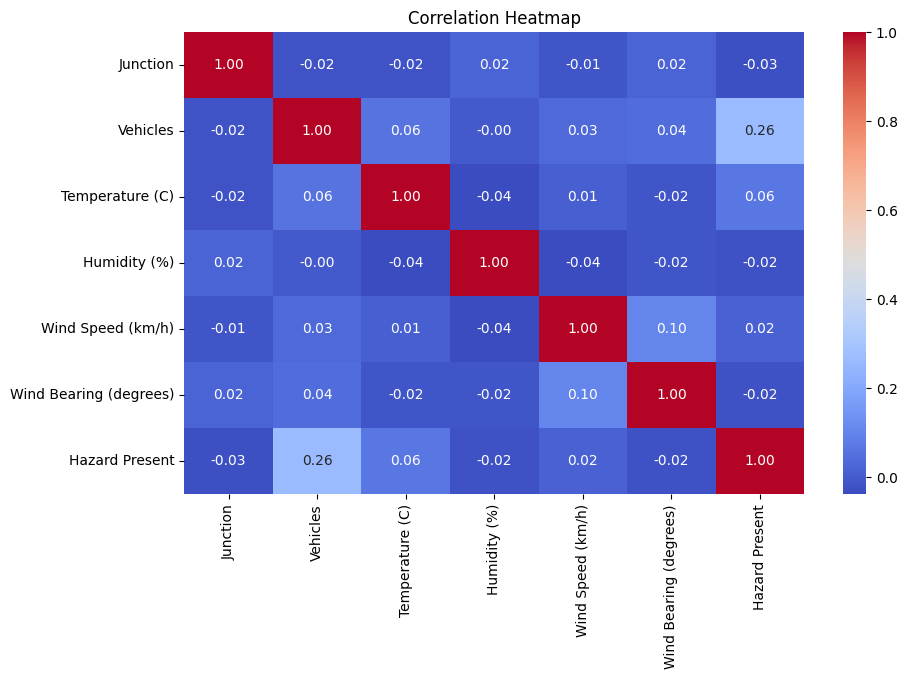

In [66]:
# Remove non-numeric columns before calculating correlation
numeric_df = df.select_dtypes(include=['number'])

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
corr_matrix = numeric_df.corr()  # Calculate correlation only for numeric columns
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


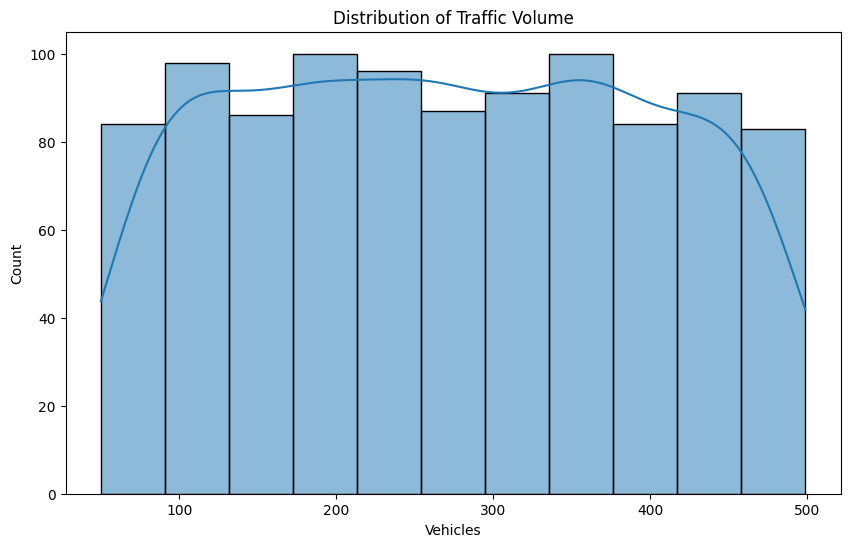

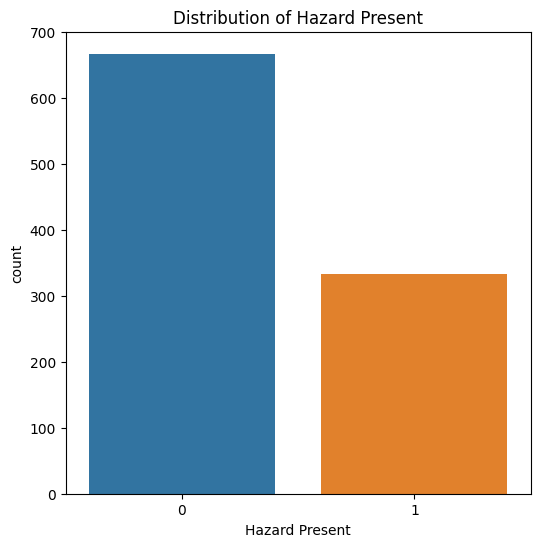

ValueError: could not convert string to float: 'Congestion'

<Figure size 1000x600 with 0 Axes>

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of traffic volume
plt.figure(figsize=(10, 6))
sns.histplot(df['Vehicles'], kde=True)
plt.title('Distribution of Traffic Volume')
plt.show()

# Plot distribution of hazard labels
plt.figure(figsize=(6, 6))
sns.countplot(x='Hazard Present', data=df)
plt.title('Distribution of Hazard Present')
plt.show()

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


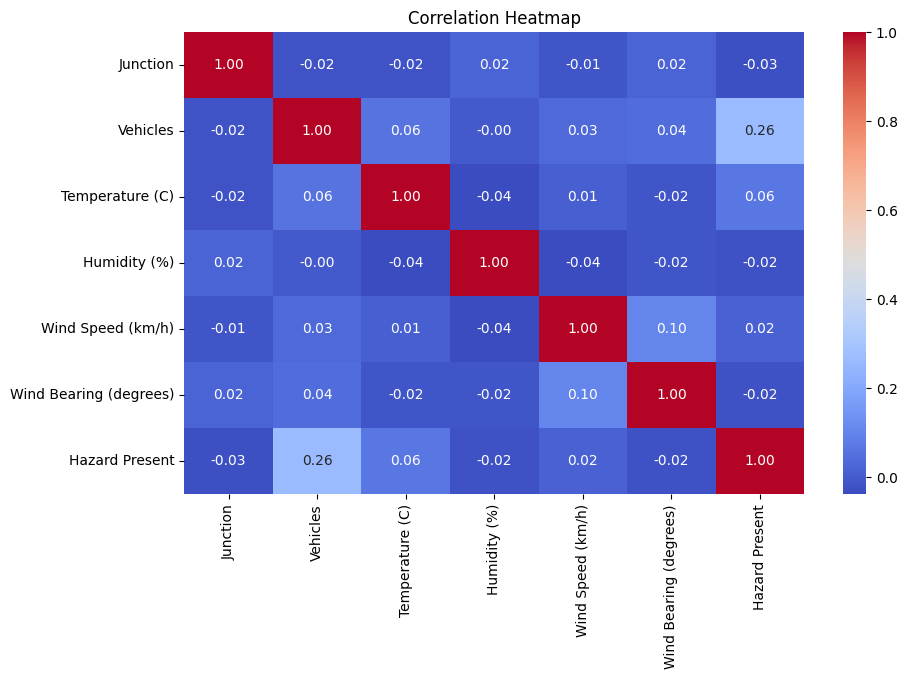

In [69]:
# Select only numeric columns from the dataframe
numeric_df = df.select_dtypes(include=['number'])

# Plot correlation heatmap for numeric columns only
plt.figure(figsize=(10, 6))
corr_matrix = numeric_df.corr()  # Calculate correlation for numeric columns only
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [72]:
# Check for missing values
print(df.isnull().sum())




DateTime                  0
Junction                  0
Vehicles                  0
Incident Type             0
Temperature (C)           0
Humidity (%)              0
Wind Speed (km/h)         0
Precipitation             0
Wind Bearing (degrees)    0
Hazard Present            0
dtype: int64


In [73]:
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek


In [80]:
from sklearn.model_selection import train_test_split

# Features (X) and target (y)
X = df[['Vehicles', 'Temperature (C)', 'Humidity (%)', 'Wind Speed (km/h)', 'Precipitation', 'Wind Bearing (degrees)', 'Hour', 'DayOfWeek']]
y = df['Hazard Present']

# Convert categorical data ('Precipitation') into numerical data
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [94]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Features (X) and target (y)
X = df[['Vehicles', 'Temperature (C)', 'Humidity (%)', 'Wind Speed (km/h)', 'Precipitation', 'Wind Bearing (degrees)', 'Hour', 'DayOfWeek']]
y = df['Hazard Present']

# Convert categorical data ('Precipitation') into numerical data
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Scale the data using StandardScaler
scaler = StandardScaler()

# Fit and transform the training data, and transform the test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Model training with Logistic Regression (with hyperparameter tuning)
# Using Pipeline to streamline the process
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=500))  # Increased max_iter to avoid convergence warnings
])

logreg_pipeline.fit(X_train_scaled, y_train)

# Step 3: Hyperparameter tuning for RandomForest using GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv=5, n_jobs=-1)
rf_grid_search.fit(X_train_scaled, y_train)

print("Best Parameters for RandomForest:", rf_grid_search.best_params_)

# Step 4: Hyperparameter tuning for SVD using GridSearchCV
param_grid_svd = {
    'svd__n_components': [5, 7, 9]  # Number of components for SVD
}

# SVD with Logistic Regression pipeline
svd_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svd', TruncatedSVD()),  # Using TruncatedSVD
    ('classifier', LogisticRegression(max_iter=500))  # Logistic Regression with higher iterations
])

# GridSearchCV for SVD pipeline
svd_grid_search = GridSearchCV(estimator=svd_pipeline, param_grid=param_grid_svd, cv=5, n_jobs=-1)
svd_grid_search.fit(X_train, y_train)

print("Best Parameters for SVD:", svd_grid_search.best_params_)

# Step 5: Model evaluation with classification report (accuracy, precision, recall, F1-score)
# RandomForest evaluation
y_pred_rf = rf_grid_search.best_estimator_.predict(X_test_scaled)
print("RandomForest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Logistic Regression evaluation
y_pred_logreg = logreg_pipeline.predict(X_test_scaled)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))

# SVD with Logistic Regression evaluation
y_pred_svd = svd_grid_search.best_estimator_.predict(X_test)
print("SVD + Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_svd))


Best Parameters for RandomForest: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 150}
Best Parameters for SVD: {'svd__n_components': 9}
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       140
           1       0.81      0.58      0.68        60

    accuracy                           0.83       200
   macro avg       0.83      0.76      0.78       200
weighted avg       0.83      0.83      0.83       200

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       140
           1       0.61      0.77      0.68        60

    accuracy                           0.79       200
   macro avg       0.75      0.78      0.76       200
weighted avg       0.81      0.79      0.79       200

SVD + Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0   

In [98]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after resampling
print(f"Resampled class distribution: {Counter(y_train_resampled)}")


Resampled class distribution: Counter({1: 527, 0: 527})


In [99]:
from sklearn.metrics import classification_report
import numpy as np

# Train your Logistic Regression model first
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predict probabilities
y_prob = log_reg.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# Set a custom threshold (e.g., 0.4 instead of 0.5)
threshold = 0.4
y_pred = (y_prob > threshold).astype(int)

# Evaluate the performance with the new threshold
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.70      0.78       140
           1       0.53      0.80      0.64        60

    accuracy                           0.73       200
   macro avg       0.71      0.75      0.71       200
weighted avg       0.78      0.73      0.74       200



In [100]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Initialize the model
xgb = XGBClassifier(random_state=42, n_estimators=100, max_depth=3)

# Train the model
xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb.predict(X_test)

# Evaluate the performance
print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       0.83      0.83      0.83       140
           1       0.60      0.60      0.60        60

    accuracy                           0.76       200
   macro avg       0.71      0.71      0.71       200
weighted avg       0.76      0.76      0.76       200



In [101]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Set hyperparameters for GridSearchCV
param_grid_log_reg = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Solver type
}

# Create the model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Perform GridSearchCV
grid_search_log_reg = GridSearchCV(estimator=log_reg, param_grid=param_grid_log_reg, cv=5, n_jobs=-1)
grid_search_log_reg.fit(X_train, y_train)

# Get the best parameters
print("Best Parameters for Logistic Regression:", grid_search_log_reg.best_params_)

# Train with the best parameters
best_log_reg = grid_search_log_reg.best_estimator_

# Evaluate the best model
y_pred_log_reg = best_log_reg.predict(X_test)
print(classification_report(y_test, y_pred_log_reg))


Best Parameters for Logistic Regression: {'C': 0.1, 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       140
           1       0.71      0.65      0.68        60

    accuracy                           0.81       200
   macro avg       0.78      0.77      0.77       200
weighted avg       0.81      0.81      0.81       200



In [103]:
import joblib

# Save the best RandomForest model after grid search
best_random_forest = grid_search.best_estimator_
joblib.dump(best_random_forest, 'random_forest_model.pkl')

# Load the model for future use
loaded_model = joblib.load('random_forest_model.pkl')

# Make predictions using the loaded model
y_pred_loaded = loaded_model.predict(X_test)
print(classification_report(y_test, y_pred_loaded))


              precision    recall  f1-score   support

           0       0.81      0.89      0.85       140
           1       0.66      0.52      0.58        60

    accuracy                           0.78       200
   macro avg       0.74      0.70      0.71       200
weighted avg       0.77      0.78      0.77       200



In [105]:
# Example new data (for prediction)
new_data = pd.DataFrame({
    'Vehicles': [100],  # Example value
    'Temperature (C)': [25],  # Example value
    'Humidity (%)': [75],  # Example value
    'Wind Speed (km/h)': [15],  # Example value
    'Precipitation': ['Rain'],  # Example categorical value
    'Wind Bearing (degrees)': [90],  # Example value
    'Hour': [15],  # Example value
    'DayOfWeek': [3]  # Example value (assuming 0 = Monday, 6 = Sunday)
})

# Preprocessing the new data (e.g., converting categorical features)
new_data = pd.get_dummies(new_data, drop_first=True)

# Make sure the new data has the same features as the training data
# This step is crucial to match the feature columns used for training.
new_data = new_data.reindex(columns=X.columns, fill_value=0)

# Use the loaded model to make predictions on the new data
new_predictions = loaded_model.predict(new_data)

# Print predictions
print(new_predictions)


[0]


In [106]:
new_data_multiple = pd.DataFrame({
    'Vehicles': [100, 200],  # Example values
    'Temperature (C)': [25, 30],  # Example values
    'Humidity (%)': [75, 60],  # Example values
    'Wind Speed (km/h)': [15, 20],  # Example values
    'Precipitation': ['Rain', 'None'],  # Example categorical values
    'Wind Bearing (degrees)': [90, 180],  # Example values
    'Hour': [15, 16],  # Example values
    'DayOfWeek': [3, 4]  # Example values
})

# Preprocess and make predictions
new_data_multiple = pd.get_dummies(new_data_multiple, drop_first=True)
new_data_multiple = new_data_multiple.reindex(columns=X.columns, fill_value=0)

predictions = loaded_model.predict(new_data_multiple)
print(predictions)


[0 0]


In [107]:
probabilities = loaded_model.predict_proba(new_data_multiple)
print(probabilities)


[[0.74456002 0.25543998]
 [0.92591481 0.07408519]]


In [108]:
new_data_multiple_class1 = [[3, 25, 75, 15, 0, 180, 10, 3],
                            [7, 28, 70, 10, 0, 210, 8, 5]]

probabilities_class1 = loaded_model.predict_proba(new_data_multiple_class1)
print(probabilities_class1)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but TruncatedSVD was fitted with feature names
  warnings.warn(


ValueError: X has 8 features, but TruncatedSVD is expecting 9 features as input.

In [109]:
# Assume your original data had a 'Precipitation' column that was encoded with pd.get_dummies()

new_data_multiple_class1 = [[3, 25, 75, 15, 0, 180, 10, 3],
                            [7, 28, 70, 10, 0, 210, 8, 5]]

# Apply the same transformation as the training data to ensure feature consistency
new_data_df = pd.DataFrame(new_data_multiple_class1, columns=['Vehicles', 'Temperature (C)', 'Humidity (%)', 'Wind Speed (km/h)', 'Precipitation', 'Wind Bearing (degrees)', 'Hour', 'DayOfWeek'])
new_data_df = pd.get_dummies(new_data_df, drop_first=True)  # Apply the same transformation used during training

# Now new_data_df should have the same number of features as your training data
probabilities_class1 = loaded_model.predict_proba(new_data_df)
print(probabilities_class1)


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Precipitation
Feature names seen at fit time, yet now missing:
- Precipitation_Rain
- Precipitation_Snow


In [110]:
# New data for prediction
new_data_multiple_class1 = [[3, 25, 75, 15, 0, 180, 10, 3],
                            [7, 28, 70, 10, 0, 210, 8, 5]]

# Create DataFrame for the new data
new_data_df = pd.DataFrame(new_data_multiple_class1, columns=['Vehicles', 'Temperature (C)', 'Humidity (%)', 'Wind Speed (km/h)', 'Precipitation', 'Wind Bearing (degrees)', 'Hour', 'DayOfWeek'])

# Apply the same transformation (pd.get_dummies) to the new data as was done during training
new_data_df = pd.get_dummies(new_data_df, drop_first=True)

# Align the columns of the new data with the training data
# Get the columns that were present during training (using the trained model)
train_columns = loaded_model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(input_features=['Vehicles', 'Temperature (C)', 'Humidity (%)', 'Wind Speed (km/h)', 'Precipitation', 'Wind Bearing (degrees)', 'Hour', 'DayOfWeek'])

# Add missing columns (for any features that are missing) and drop extra columns
new_data_df = new_data_df.reindex(columns=train_columns, fill_value=0)

# Now, make predictions using the loaded model
probabilities_class1 = loaded_model.predict_proba(new_data_df)
print(probabilities_class1)


KeyError: 'preprocessor'

In [111]:
# Check the pipeline structure to see the names of steps
print(loaded_model.named_steps)


{'svd': TruncatedSVD(n_components=9), 'classifier': LogisticRegression(C=0.1)}


In [112]:
import pandas as pd
import numpy as np

# Example of new data (replace with your actual new data)
new_data = np.array([[7, 28, 70, 10, 0, 210, 8, 5]])  # Add more rows if needed

# Since we don't have 'Precipitation_Rain' and 'Precipitation_Snow' columns in new_data,
# we can either generate them or re-align with the expected features in the training data.
# If your data had 'Precipitation' encoded as multiple columns, ensure those are present here.

# You might need to ensure that the column order of `new_data` is exactly the same as training data
# Apply TruncatedSVD transformation to reduce dimensions for new data

# Ensure the new data has the same number of features as during training
# This should align with how your pipeline's TruncatedSVD expects the data
new_data_df = pd.DataFrame(new_data, columns=['Vehicles', 'Temperature (C)', 'Humidity (%)', 'Wind Speed (km/h)', 'Precipitation', 'Wind Bearing (degrees)', 'Hour', 'DayOfWeek'])

# Apply the same transformation (TruncatedSVD) as was done during training
new_data_transformed = loaded_model.named_steps['svd'].transform(new_data_df)

# Make predictions using the logistic regression classifier in the pipeline
probabilities_class1 = loaded_model.named_steps['classifier'].predict_proba(new_data_transformed)

# Print the probabilities for class 1
print(probabilities_class1)


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Precipitation
Feature names seen at fit time, yet now missing:
- Precipitation_Rain
- Precipitation_Snow


In [113]:
import pandas as pd

# Example input for Class 1 (similar to what you provided)
new_data_class1 = pd.DataFrame({
    'Vehicles': [150, 250],  # Example values
    'Temperature (C)': [22, 28],  # Example values
    'Humidity (%)': [65, 80],  # Example values
    'Wind Speed (km/h)': [10, 25],  # Example values
    'Precipitation': ['Rain', 'Snow'],  # Example categorical values
    'Wind Bearing (degrees)': [75, 180],  # Example values
    'Hour': [14, 17],  # Example values
    'DayOfWeek': [2, 5]  # Example values
})

# Apply one-hot encoding (e.g., for 'Precipitation' and other categorical features)
new_data_class1 = pd.get_dummies(new_data_class1, drop_first=True)

# Ensure that new data has the same columns as the training data, including missing columns
new_data_class1 = new_data_class1.reindex(columns=X.columns, fill_value=0)

# Make predictions using the loaded model
predictions_class1 = loaded_model.predict(new_data_class1)
print(predictions_class1)


[0 0]


In [114]:
probabilities_class1 = loaded_model.predict_proba(new_data_class1)
print(probabilities_class1)


[[0.87335003 0.12664997]
 [0.79919105 0.20080895]]
